# Прогнозирование температуры звезды

# Содержание

1. [Загрузка данных](#1)
2. [Предобработка и исследовательсикй анализ данных](#2)
3. [Построение базовой нейронной сети](#3)
3. [Улучшение нейронной сети](#4)
4. [Выводы](#5)

Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Заказчик - обсерватория «Небо на ладони» - хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.


**Цель проекта** - с помощью нейросети определить температуру на поверхности обнаруженных звёзд. 

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Описание данных**
 
Признаки:

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.

Целевой признак:

- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.


**Задачи проекта**:

- Предобработать и провести исследовательский анализ данных.
- Построить и обучить простую модель нейронной сети — baseline.
- Улучшить сеть.


## Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import random

from math import ceil, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn



## Загрузка данных <a id="1"></a>

In [2]:
server_path = '/datasets/6_class.csv'   
local_path = ''               
try:
    df = pd.read_csv(server_path)   
except: 
    df = pd.read_csv(local_path)  

In [3]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Сразу удалим колонку с индексами и для удобства работы упростим названия остальных.

In [4]:
df = df.iloc[:,1:]
df.columns = ['temperature', 'luminosity', 'radius', 'magnitude','star_type','star_color']

Разделим данные на признаки.

In [5]:
num_cols = ['luminosity','radius','magnitude'] #числовые признаки
cat_cols = ['star_type', 'star_color'] #категориальные признаки
target = ['temperature'] #целевой признак

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Пропусков не обнаружено.

In [7]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [8]:
df['star_color'].unique() 

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [9]:
df['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

В колонке star_color есть неявные дубликаты, исправим в следующем пункте.

In [10]:
df.describe(include = 'all')

,temperature,luminosity,radius,magnitude,star_type,star_color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,Red
freq,NaN,NaN,NaN,NaN,NaN,112
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,NaN
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,NaN
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,NaN
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,NaN
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,NaN
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,NaN


- temperature содержит значения от 2000 градусов (красные звёзды) до 40000 градусов (голубые звезды).
- В характеристиках luminosity, radius, magnitude очень большой разброс значений.
- В star_color 19 уникальных значений. Нужно обработать.

## Предобработка и анализ данных <a id="2"></a>

Исправим значения колонки star_color.

In [11]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
Blue white              1
Blue-White              1
White-Yellow            1
Orange-Red              1
Yellowish               1
Blue                    1
Name: star_color, dtype: int64

Спектральная классификация делит звезды в порядке уменьшения температуры, от более голубых к более красным(классы O, B, A, F, G, K, M). Создадим функцию, чтобы перезаписать цвет звезды.

In [12]:
def star_color(x):
    if x > 30000:
        return 'blue'
    elif 30000 >= x > 10000:
        return 'blue_white'
    elif 10000 >= x > 7400:
        return 'white'
    elif 7400 >= x > 6000:
        return 'yellow_white'
    elif 6000 >= x > 5000:
        return 'yellow'
    elif 5000 >= x > 3800:
        return 'orange'
    else:
        return 'red'

In [13]:
df['star_color'] = df['temperature'].apply(star_color)

In [14]:
df['star_color'].value_counts()

red             109
blue_white       76
white            21
blue             14
yellow_white      7
orange            7
yellow            6
Name: star_color, dtype: int64

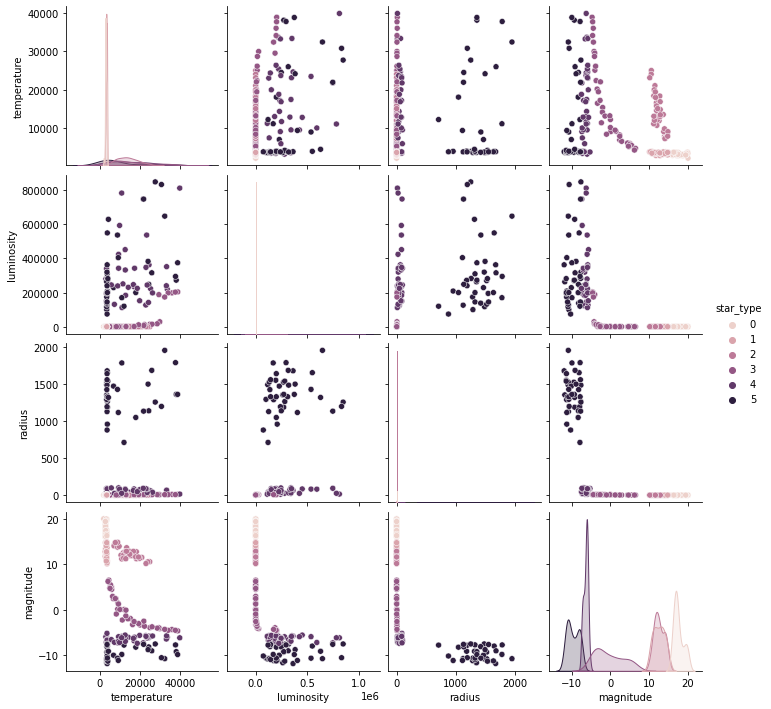

In [15]:
sns.pairplot(df, hue='star_type');

- С увеличением температуры начинает уменьшаться абсолютная звёздная величина.
- При помощи радиуса можно выделить тип звезды.
- Хорошо выделяются кластеры типа звезды в зависимости от абсолютной звёздой величины.

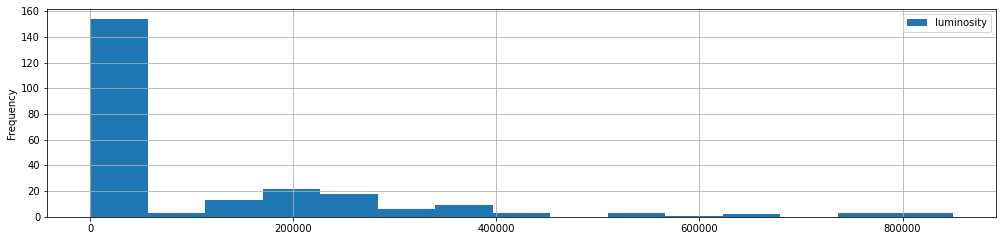

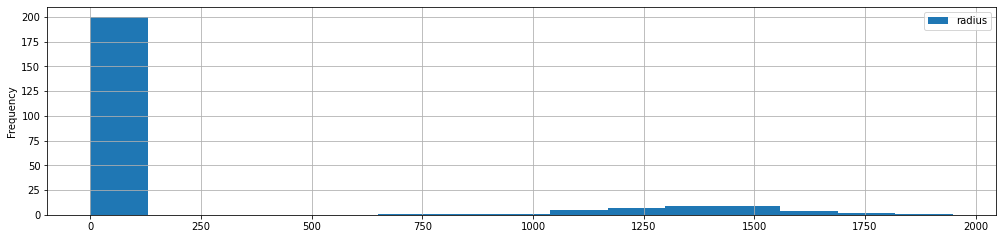

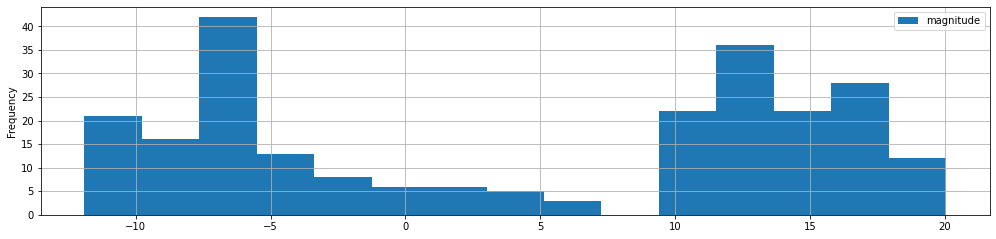

In [16]:
fig = plt.figure()
for i in range(len(num_cols)):
    plt.subplot(len(num_cols), 1, i+1)
    df[num_cols[i]].plot(kind = 'hist', bins = 15, grid = True, legend = num_cols[i], figsize = (17,13))
    plt.show()

В первых двух столбцах большинство значений находится в диапазоне от 0 до 150, но задача связана с астрономией, а датасет не такой большой, чтобы обрабатывать его от выбросов. Попробуем оставить данные как есть.

In [17]:
df['star_type'] = df['star_type'].astype(dtype='object')

In [18]:
df.duplicated().sum() 

0

## Построение базовой нейронной сети <a id="3"></a>

Подготовим данные для нейронной сети.

In [19]:
X = df.drop(target, axis = 1).copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)
    
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

encoder = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

X_train_cat = pd.DataFrame(encoder.fit_transform(X_train.loc[:,cat_cols]))
X_train_cat.columns = encoder.get_feature_names(cat_cols)
X_train.drop(cat_cols, axis = 1, inplace = True)
X_train = pd.concat([X_train, X_train_cat], axis = 1)

X_test_cat = pd.DataFrame(encoder.transform(X_test.loc[:,cat_cols]))
X_test_cat.columns = encoder.get_feature_names(cat_cols)
X_test.drop(cat_cols, axis = 1, inplace = True)
X_test = pd.concat([X_test, X_test_cat], axis = 1)


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(192, 14) (48, 14)
(192, 1) (48, 1)


/tmp/ipykernel_189/3504565368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_189/3504565368.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

Переведём данные к тензорам.

In [20]:
X_train = torch.FloatTensor(X_train.values)
X_test  = torch.FloatTensor(X_test.values)
y_train  = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Настроим количество нейронов на слоях сети.

In [21]:
n_in_neurons = 14
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 20
n_out_neurons = 1

Создадим класс для задания архитектуры нейронной сети.

In [22]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x       

In [23]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #модель 
loss=nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [24]:
def cross_vall_score(model, X_train, y_train, optim, num_epochs, batch_size, k=4, loss=nn.MSELoss()):
    '''Функция для кросс-валидации нейронной сети'''
    num_batches = ceil(len(X_train)/batch_size) # количество батчей 
    num_val_samples = len(X_train)//k # размер валидационной выборки 
    all_scores = []
    
    for i in range(k): 
        #разбиваем на валидационную и тренировочную выборку 
        print('processing fold #', i+1, end='  ')
        
        #обнуляем веса нейронной сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        #валидационная выборка
        val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
        val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
        
        #тренировочная выборка
        partial_train_data = np.concatenate([X_train[:i*num_val_samples], X_train[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis = 0)
        
        #приводим наши данные к формату FloatTensor
        val_data = torch.FloatTensor(val_data)
        val_targets = torch.FloatTensor(val_targets)
        partial_train_data = torch.FloatTensor(partial_train_data)
        partial_train_targets = torch.FloatTensor(partial_train_targets)
        
        for epoch in range(num_epochs):
            #создаем случайную перестановку индексов для каждой эпохи
            order = np.random.permutation(len(partial_train_data))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size #стартовый индекс батча
                optim.zero_grad() #обнуляем градиаенты
                
                #извлекаем батч
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = partial_train_data[batch_indexes]
                y_batch = partial_train_targets[batch_indexes]
                
                preds = net.forward(X_batch).flatten() #получаем предсказание
                loss_value = loss(preds, y_batch.flatten()) #высчитываем ошибку
                loss_value.backward()
                optim.step()
                
            if epoch == num_epochs-1:
                model.eval()
                val_preds = model.forward(val_data)
                RMSE_loss = torch.sqrt(loss(val_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)),  '\n')
    return

In [25]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, X_train, y_train, i, 250,6)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5103.88916015625
processing fold # 2  RMSE метрика = 5865.4267578125
processing fold # 3  RMSE метрика = 4580.87255859375
processing fold # 4  RMSE метрика = 5860.73974609375
Средняя RMSE метрика = 5352 

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5318.1103515625
processing fold # 2  RMSE метрика = 6392.1640625
processing fold # 3  RMSE метрика = 4892.75830078125
processing fold # 4  RMSE метрика = 7491.51220703125
Средняя RMSE метрика = 6023 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 3907.029052734375
processing fold # 2  RMSE метрика = 3246.30029296875
processing fold # 3  RMSE метрика = 3022.022216

Лучше всего себя показала оптимизация Adamax с шагом сходимости в 0.01.

In [26]:
def neiron(model, X_train, y_train, optim, batch_size, num_epochs = 250):
    '''Функция обучает нейронную сеть батчами с заданным количеством эпох'''
    num_batches = ceil(len(X_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            batch_indexes = order[start_index:start_index+batch_size] #индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = model.forward(X_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model

In [27]:
net = neiron(net, X_train, y_train, optimizer3, batch_size=6) #обучаем модель с заданными параметрами 

In [28]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3518


In [29]:
def vizualization(target, preds, width = 0.3):
    '''Визуализирует предсказания нейронной сети на тестовой выборке'''
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    
    fig,ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label = 'Факт')
    rects2 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    fig.set_figwidth(17)
    fig.set_figheight(10)
    ax.legend();

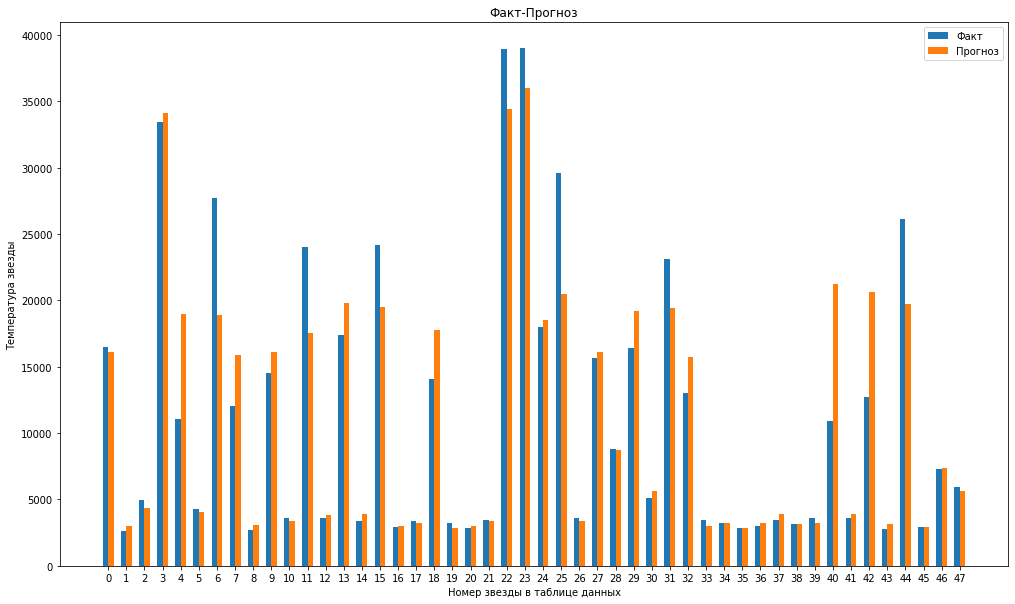

In [30]:
vizualization(y_test, test_preds)

Нейронная сеть очень хорошо предсказывает температуру звёзд, у которых значение до 5000 градусов. В целом, по графику видно, что модель не сильно ошибается.

## Улучшение нейронной сети <a id="4"></a>

Для улучшения нейронной сети попробуем применить Dropout и изменить размер батча. Далее проверим, позволят ли данные методы улучшить нашу нейронную сеть.

In [31]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dp):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=dp)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x       

In [32]:
for i in [0.2, 0.3, 0.7]:
    net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,i) 
    loss=nn.MSELoss()
    print('dp=', i)
    for y in [3, 6, 8, 12, 16]:
        print('batch_size=', y)
        cross_vall_score(net, X_train, y_train, torch.optim.Adamax(net.parameters(), lr=1e-2), 250, y)

dp= 0.2
batch_size= 3
processing fold # 1  RMSE метрика = 3659.973876953125
processing fold # 2  RMSE метрика = 3145.897216796875
processing fold # 3  RMSE метрика = 2455.226318359375
processing fold # 4  RMSE метрика = 3423.6552734375
Средняя RMSE метрика = 3171 

batch_size= 6
processing fold # 1  RMSE метрика = 3848.62060546875
processing fold # 2  RMSE метрика = 3700.69677734375
processing fold # 3  RMSE метрика = 2607.563232421875
processing fold # 4  RMSE метрика = 3888.0400390625
Средняя RMSE метрика = 3511 

batch_size= 8
processing fold # 1  RMSE метрика = 3787.241943359375
processing fold # 2  RMSE метрика = 4704.1650390625
processing fold # 3  RMSE метрика = 3162.466064453125
processing fold # 4  RMSE метрика = 4025.2275390625
Средняя RMSE метрика = 3919 

batch_size= 12
processing fold # 1  RMSE метрика = 4416.78515625
processing fold # 2  RMSE метрика = 4679.2890625
processing fold # 3  RMSE метрика = 3928.552001953125
processing fold # 4  RMSE метрика = 4252.68359375
Сред

Лучший результат получили при значении dropout=0.2 и размере батча = 3.

Сохраним модель с параметрами.

In [34]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 0.2) 
loss=nn.MSELoss()

In [35]:
cross_vall_score(net, X_train, y_train, torch.optim.Adamax(net.parameters(), lr=1e-2), 250, 3)

processing fold # 1  RMSE метрика = 3661.970947265625
processing fold # 2  RMSE метрика = 3112.0556640625
processing fold # 3  RMSE метрика = 2615.41650390625
processing fold # 4  RMSE метрика = 3561.285888671875
Средняя RMSE метрика = 3237 



In [36]:
net = neiron(net, X_train, y_train, torch.optim.Adamax(net.parameters()), batch_size=3)

In [37]:
net.eval()
test_preds = net.forward(X_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  3501


Получилось немного, но улучшить модель.

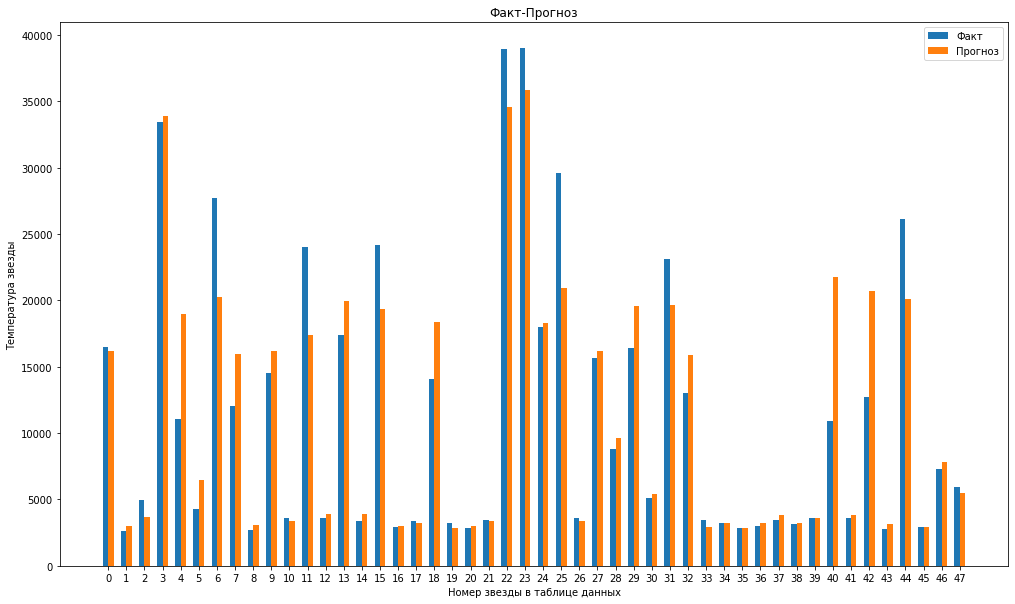

In [38]:
vizualization(y_test, test_preds)

## Выводы <a id="5"></a>

В ходе проекта была построена модель нейронной сети. При использовании подобранной оптимизации Adamax с шагом сходимости в 0.01, размером батча = 3 и исключением, равным 0.3, удалось достичь значения метрики rmse = 3501. Полученная нейронная сеть отлично предсказывает температуру звёзд до 5000 градусов. По графикам, представленным в проекте, видно, что модель в целом хорошо справляется с поставленной задачей.